In [120]:
import gspread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import networkx as nx

from collections import Counter
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from google.oauth2.service_account import Credentials

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozy.prazuganda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [111]:
SERVICE_ACCOUNT_FILE = 'key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open('Suara Bukan Manusia').worksheet('Sheet1')
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tanggal Pengerjaan  589 non-null    object
 1   Nama                589 non-null    object
 2   ASI/AFI             589 non-null    object
 3   Call ID             589 non-null    object
 4   Detik               589 non-null    object
 5   teks robot          589 non-null    object
 6   Recording           589 non-null    object
dtypes: object(7)
memory usage: 32.3+ KB


In [118]:
# copying dataframe
df_clean = df.copy()

cat_cols = ['Nama', 'ASI/AFI', 'teks robot']

df_clean = (
    df_clean
    .rename(columns=lambda c: c.strip() if isinstance(c, str) else c)
    .replace({'': pd.NA})
    .dropna(subset=['teks robot'], how='all')
    .drop(columns=['Recording'], errors='ignore')
    .assign(**{
        c: lambda _d, c=c: _d[c].astype(str).str.strip() if c in _d.columns else _d.get(c) for c in cat_cols
    })
)

# date
if 'Tanggal Pengerjaan' in df_clean.columns:
    df_clean['Tanggal Pengerjaan'] = pd.to_datetime(df_clean['Tanggal Pengerjaan'], errors='coerce')

existing_cat_cols = [c for c in cat_cols if c in df_clean.columns]
if existing_cat_cols:
    df_clean = df_clean.astype({c: 'category' for c in existing_cat_cols})

# inspect
df_clean

,Tanggal Pengerjaan,Nama,ASI/AFI,Call ID,Detik,teks robot
0,2025-10-01,Neneng,ASI,c866a85acb9f43b98a67cd94f1ecaf2c,2025-09-30 15:31:55,apa
1,2025-10-01,Aul,ASI,22a99d25481048999cdbb78f1efc646e,2025-09-30 21:01:01,apa ya
2,2025-10-01,Aul,AFI,2ea5529131e14db28d936806a8282b11,2025-09-30 20:31:46,nih
3,2025-10-01,Aul,AFI,dc20654a91d148da8c4020245888cc60,2025-09-30 18:17:05,motor
4,2025-10-01,Neneng,AFI,78ee689a490f48ad9f2c34a590be301f,2025-09-30 16:53:39,apa ya
...,...,...,...,...,...,...
548,2025-10-30,Aul,AFI,3219c6680c7342c59f9ce98f8f4dba02,2025-10-29 13:19:50,apa ya
549,2025-10-30,Neneng,ASI,5491a65813794b95ac7cc317771600a4,2025-10-30 7:22:37,he em
550,2025-10-30,Neneng,ASI,5491a65813794b95ac7cc317771600a4,2025-10-30 7:26:13,he em
552,2025-10-30,Neneng,AFI,c042c320d63d4af9afaf0f49f2e0b744,2025-10-29 14:29:43,lowongan


### The Analysis

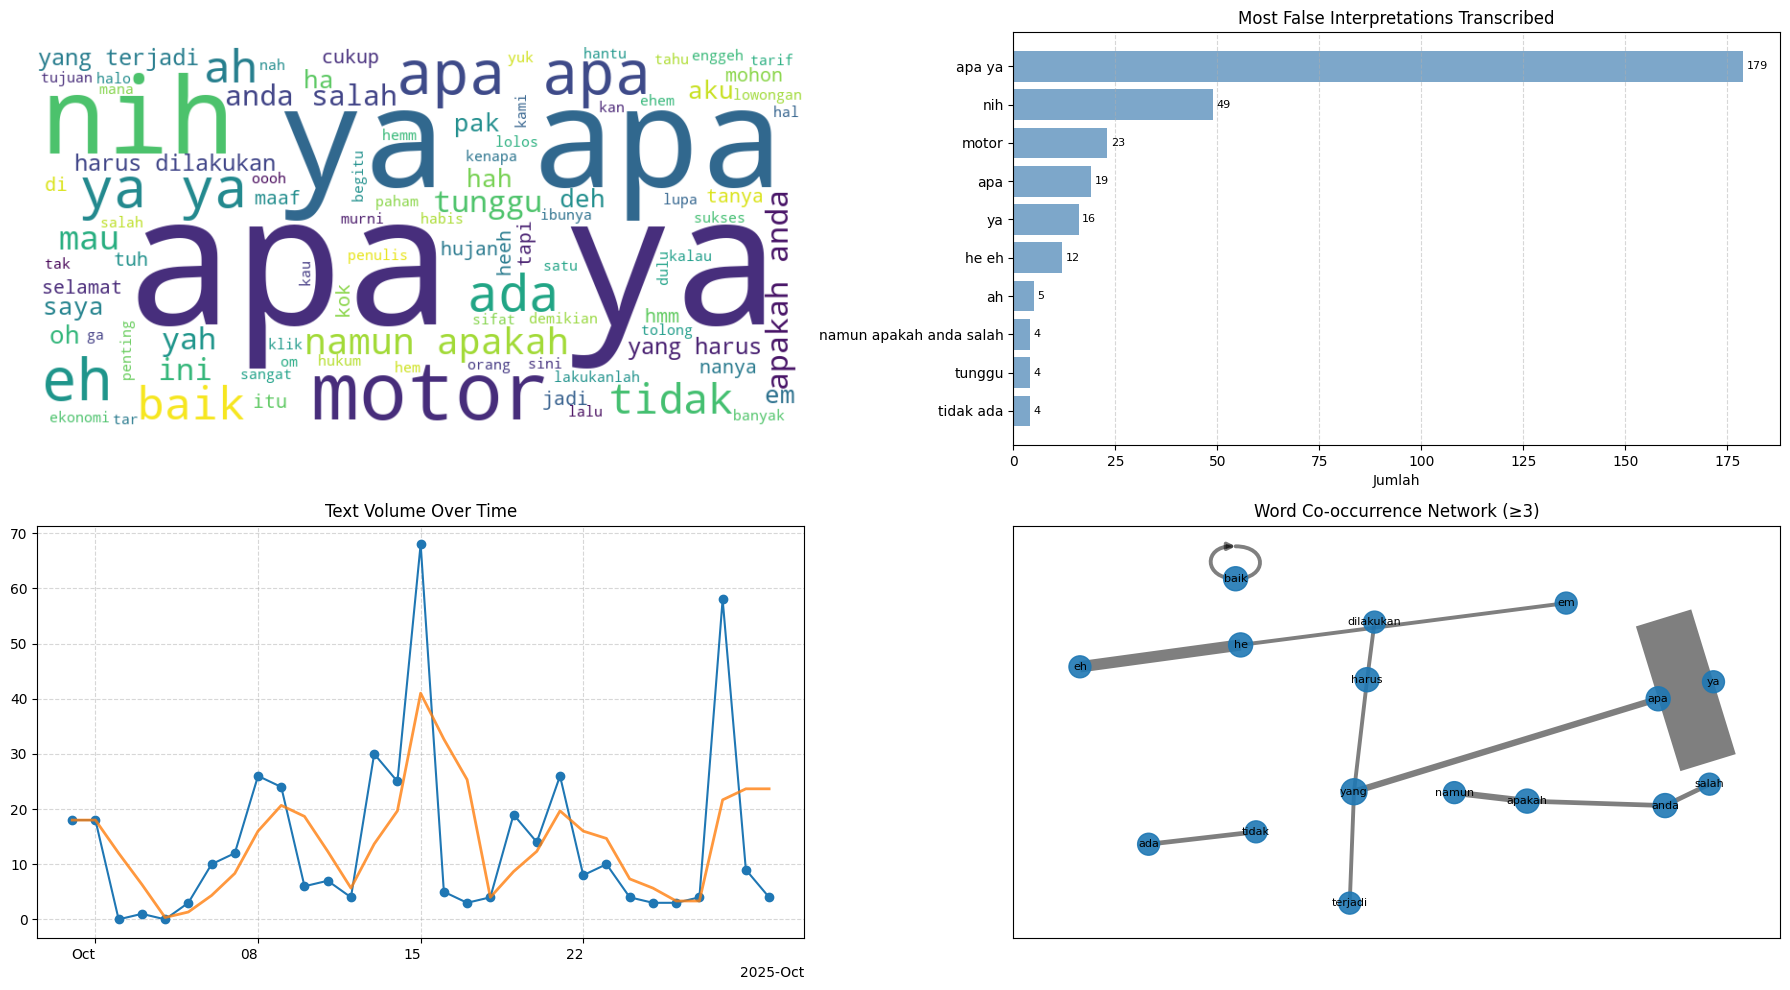

In [139]:
# Subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Wordcloud
text = ' '.join(df_clean['teks robot'].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

axes[0,0].imshow(wordcloud, interpolation='bilinear')
axes[0,0].axis('off')

# H bar plot
count = df_clean['teks robot'].value_counts().sort_values(ascending=True).tail(10)

ax = axes[0,1]
bars = ax.barh(count.index, count.values, color='steelblue', alpha=0.7)
ax.set_title('Most False Interpretations Transcribed')
ax.set_xlabel('Jumlah')
ax.axis('tight')
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

numbers = max(count.values) if len(count.values) else 0
for bar in bars:
    w = bar.get_width()
    ax.text(w + (numbers * 0.005), bar.get_y() + bar.get_height()/2, f'{int(w)}', va='center', fontsize=8)

# Line Plot
df_clean['Detik'] = pd.to_datetime(df_clean['Detik'])
df_clean = df_clean.sort_values('Detik')

s = (df_clean.set_index('Detik')
       .resample('D')['teks robot']
       .count()
      )

s_ma = s.rolling(window=3, min_periods=1).mean()

ax_line = axes[1,0]
ax_line.plot(s.index, s.values, marker='o', linewidth=1.5)
ax_line.plot(s_ma.index, s_ma.values, linewidth=2, alpha=0.8)

locator = AutoDateLocator(minticks=7, maxticks=8)
ax_line.xaxis.set_major_locator(locator)
ax_line.xaxis.set_major_formatter(ConciseDateFormatter(locator))
for label in ax_line.get_xticklabels():
    label.set_horizontalalignment('right')

ax_line.set_title('Text Volume Over Time')
ax_line.grid(True, linestyle='--', alpha=0.5)

# Network Graph
pairs = []
for sent in df_clean['teks robot'].dropna().astype(str):
    tokens = sent.split()
    pairs += [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

G = nx.DiGraph()
for (a, b), w in Counter(pairs).items():
    if w > 2:
        G.add_edge(a, b, weight=w)

ax_net = axes[1,1]
ax_net.set_title('Word Co-occurrence Network (≥3)')

if G.number_of_edges() == 0:
    ax_net.text(0.5, 0.5, 'no edges to display', horizontalalignment='center', verticalalignment='center')
    ax_net.axis('off')
else:
    pos = nx.spring_layout(G, k=0.6, seed=42)
    edge_w = [1 + 0.6 * G[u][v]['weight'] for u, v, in G.edges()]
    node_sizes = [200 + 50 * d for _, d in G.degree()]

    nx.draw_networkx_nodes(G, pos, ax=ax_net, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, ax=ax_net, width=edge_w, alpha=0.5, arrows=False)
    nx.draw_networkx_labels(G, pos, ax=ax_net, font_size=8)

plt.tight_layout()